In [1]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Replace 'df.csv' with the actual path to your file in Google Drive if it's not in the root directory
file_path = '/content/drive/My Drive/image.csv'

# 读取数据，time列解析为日期但不设为索引
image = pd.read_csv(file_path, parse_dates=['time'])

display(image.head())
image.dtypes


,time,image_path
0,2008-01-01,/content/drive/My Drive/landsat5/p08-1.tif
1,2008-04-01,/content/drive/My Drive/landsat5/p08-2.tif
2,2008-07-01,/content/drive/My Drive/landsat5/p08-3.tif
3,2008-10-01,/content/drive/My Drive/landsat5/p08-4.tif
4,2009-01-01,/content/drive/My Drive/landsat5/Q1.tif


,0
time,datetime64[ns]
image_path,object


# Task
Extract the `time` and `image_path` columns from the input dataframe into a new dataframe named `image`. Load the satellite images from the paths in the `image_path` column, normalize them (checking shape and normalization factor), and tile them. Use a pre-trained RESNET-18 model (without the final classification layer) with GPU acceleration to extract 512-dimensional features from each tile. Aggregate the features from the tiles belonging to the same original image and add these aggregated features as columns named `d1` to `d512` to the `image` dataframe.

## Create a new dataset with `time` and `image path` columns

### Subtask:
Extract the `time` and `image_path` columns from the original DataFrame `df` into a new DataFrame named `image`.


**Reasoning**:
Extract the specified columns into a new DataFrame and display the head.



## Load and preprocess images

### Subtask:
Load each image from the `image_path` column of the `image` DataFrame, normalize each image by dividing by 65535.0 (as these are 16-bit images), and check the shape of the loaded images.


**Reasoning**:
Iterate through the image paths, load each image, normalize it, and store the normalized image data in a new column of the `image` dataframe. Also, check the shape of each image.



In [3]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 99.2 MB/s eta 0:00:00


### Subtask: Check raw image data stats after loading

Let's check the minimum, maximum, and data type of the raw image data immediately after loading with `rasterio`, before any band selection or normalization, to see if `NaN` values are present at this stage.

**Reasoning**:
Load the image data using `rasterio.open().read()` and immediately print the min, max, and dtype of the resulting NumPy array. This will help isolate whether the `NaN` values are introduced during loading or in subsequent processing steps.

In [4]:
import rasterio
import numpy as np

def check_raw_image_stats(image_path, row_index):
    """Loads an image and prints its raw min, max, and dtype."""
    print(f"--- Raw Stats for image from row {row_index} ({image_path}) ---")
    try:
        with rasterio.open(image_path) as src:
            raw_img_data = src.read()

            print(f"Raw Min pixel value: {np.nanmin(raw_img_data)}") # Use nanmin to ignore NaNs if present
            print(f"Raw Max pixel value: {np.nanmax(raw_img_data)}") # Use nanmax to ignore NaNs if present
            print(f"Raw Data type: {raw_img_data.dtype}")
            print(f"Raw Shape: {raw_img_data.shape}")
            # Also check if there are any NaN values in the raw data
            print(f"Contains NaN values: {np.isnan(raw_img_data).any()}")

    except Exception as e:
        print(f"Error loading raw image from {image_path}: {e}")
    print("-" * (len(f"--- Raw Stats for image from row {row_index} ({image_path}) ---")))

# Get the image paths for row 0 and row 20
image_path_row_0 = image.loc[0, 'image_path']
image_path_row_12 = image.loc[12, 'image_path']

# Check raw stats for the image in row 0
check_raw_image_stats(image_path_row_0, 0)

# Check raw stats for the image in row 20
check_raw_image_stats(image_path_row_12, 12)

--- Raw Stats for image from row 0 (/content/drive/My Drive/landsat5/p08-1.tif) ---
Raw Min pixel value: 8500.0
Raw Max pixel value: 30000.0
Raw Data type: float64
Raw Shape: (19, 1836, 3415)
Contains NaN values: True
-----------------------------------------------------------------------------------
--- Raw Stats for image from row 12 (/content/drive/My Drive/landsat5/Q9.tif) ---
Raw Min pixel value: 8500.0
Raw Max pixel value: 30000.0
Raw Data type: float64
Raw Shape: (19, 1836, 3415)
Contains NaN values: True
---------------------------------------------------------------------------------


# Task
Extract the 'time' and 'image_path' columns from the input data into a new dataframe called 'image'. Then, for each image path in the 'image' dataframe, load the image, select the RGB bands (bands 2, 1, 0 for Landsat 5/7), fill NaN values with 0, and normalize the pixel values to the range [0, 1]. Tile each processed image. Load a pre-trained RESNET-18 model, remove the final classification layer, and use it with GPU acceleration to extract 512-dimensional features from each tile. Aggregate the features from all tiles of a single image into a single 512-dimensional vector. Add these aggregated features as new columns named 'd1' through 'd512' to the 'image' dataframe, aligning them with the corresponding 'time' values. Finally, display the updated 'image' dataframe.

## Load pre-trained resnet-18 model

### Subtask:
Load the RESNET-18 model using a deep learning framework (like PyTorch) and remove the final classification layer to use it as a feature extractor. Configure the model to use GPU acceleration.


**Reasoning**:
Load the ResNet-18 model, remove the final layer, set it to evaluation mode, and move it to the appropriate device (GPU if available, otherwise CPU).



In [5]:
import torch
import torchvision.models as models

# Load the pre-trained ResNet-18 model
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Remove the final classification layer (the fully connected layer)
# Access the last layer of the model and replace it with an Identity layer
num_ftrs = resnet18.fc.in_features
resnet18.fc = torch.nn.Identity()

# Set the model to evaluation mode
resnet18.eval()

# Check for GPU availability and move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)

print(f"Using device: {device}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


Using device: cuda


# Task
Extract the 'time' and 'image_path' columns from the input data into a new DataFrame called `image`. Then, for each image path in the `image` DataFrame, load the image, select the RGB bands (reordering to RGB), fill NaN values with 0, and normalize the pixel values to the range [0, 1]. Tile each processed image. Load a pre-trained RESNET-18 model, remove the final classification layer, and use it with GPU acceleration to extract 512-dimensional features from each tile. Aggregate the features from all tiles of a single image into a single 512-dimensional vector. Add these aggregated features as new columns named 'd1' through 'd512' to the `image` DataFrame, aligning them with the corresponding 'time' entries. Ensure that image data and tiles are discarded from memory after processing each image to manage RAM usage. Finally, display the updated `image` DataFrame.

## Define tiling strategy

### Subtask:
Define the size of the tiles and the method for splitting the image into tiles.


**Reasoning**:
Define the tile size as instructed.



In [6]:
# Define the tile size
tile_size = 224

print(f"Tile size defined as: {tile_size}x{tile_size}")

Tile size defined as: 224x224


## Iterate and process each image (load, preprocess, tile, extract features, aggregate)

### Subtask:
Iterate through each image path in the `image` DataFrame. For each image, load it, select RGB bands, fill NaN values with 0, normalize to [0, 1], tile it, extract features using the pre-trained ResNet-18 model on the GPU, aggregate features from all tiles, and store the aggregated features with the corresponding time. Discard image data and tiles after processing each image.


**Reasoning**:
Iterate through the image paths, load, preprocess, tile, extract features, aggregate, and store features, managing memory.

next time try not use normalized_img_data = handled_nan_data / 65535.0



In [7]:
from torchvision import transforms
import torch.nn.functional as F
import rasterio
import numpy as np
import torch # Ensure torch is imported here if not globally available

# Initialize an empty list to store the aggregated feature vectors for all images
all_image_features = []

# Loop through each row of the image DataFrame
for index, row in image.iterrows():
    image_path = row['image_path']
    print(f"Processing image: {image_path} (Row {index+1}/{len(image)})")

    try:
        # Open the image file
        with rasterio.open(image_path) as src:
            # Read RGB bands in RGB order (1-based indices: 3 for Red, 2 for Green, 1 for Blue)
            # rasterio.read() expects 1-based indices
            if src.count >= 3:
                img_data = src.read([3, 2, 1]).astype(np.float32) # Read directly as float32

                # Handle NaN values: Fill with 0 as requested by the user
                handled_nan_data = np.nan_to_num(img_data, nan=0.0)

                # Normalize the pixel values to [0, 1]
                normalized_img_data = handled_nan_data / 65535.0

                # Get image dimensions
                channels, height, width = normalized_img_data.shape

                # Determine padding needed
                pad_height = (tile_size - (height % tile_size)) % tile_size
                pad_width = (tile_size - (width % tile_size)) % tile_size

                # Apply padding to the normalized image data (pad last two dimensions: height, width)
                # Padding format is ((before_1, after_1), (before_2, after_2), ...)
                padded_img_data = np.pad(normalized_img_data, ((0, 0), (0, pad_height), (0, pad_width)), mode='constant', constant_values=0)

                # Get padded image dimensions
                padded_channels, padded_height, padded_width = padded_img_data.shape

                # Initialize an empty list to store features for the tiles of the current image
                image_tile_features = []

                # Iterate through the padded image in steps of tile_size to create tiles
                for h in range(0, padded_height, tile_size):
                    for w in range(0, padded_width, tile_size):
                        # Extract tile
                        tile = padded_img_data[:, h:h+tile_size, w:w+tile_size]

                        # Convert tile to PyTorch tensor, add batch dimension, move to device
                        tile_tensor = torch.from_numpy(tile).unsqueeze(0).to(device) # Shape: (1, C, H, W)

                        # Use torch.no_grad() to disable gradient calculation
                        with torch.no_grad():
                            # Pass the tile tensor through the pre-trained resnet18 model
                            features = resnet18(tile_tensor) # Shape: (1, 512)

                        # Move the extracted features back to the CPU and convert to NumPy array
                        features_np = features.squeeze(0).cpu().numpy() # Shape: (512,)

                        # Append the NumPy array of features to the list storing tile features
                        image_tile_features.append(features_np)

                        # Explicitly delete tile tensor to free memory
                        del tile_tensor
                        if torch.cuda.is_available():
                            torch.cuda.empty_cache()


                # Aggregate the tile features by calculating the mean across all tile feature vectors
                if image_tile_features: # Check if the list is not empty
                    aggregated_features = np.mean(image_tile_features, axis=0) # Shape: (512,)
                else:
                    # Handle case where no tiles were generated (e.g., image too small, though padding should prevent this)
                    aggregated_features = np.zeros(num_ftrs, dtype=np.float32)
                    print(f"Warning: No tiles generated for image {image_path}. Appending zero vector.")


                # Append the aggregated feature vector to the list storing aggregated features for all images
                all_image_features.append(aggregated_features)

                # Explicitly delete image data and tile features list to free memory
                del img_data, handled_nan_data, normalized_img_data, padded_img_data, image_tile_features
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            else:
                print(f"Image {image_path} does not have at least 3 bands after reading. Appending zero vector.")
                all_image_features.append(np.zeros(num_ftrs, dtype=np.float32))


    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        # Append a placeholder (e.g., a vector of zeros) for this image if processing fails
        all_image_features.append(np.zeros(num_ftrs, dtype=np.float32))
        # Attempt to free memory even if an error occurred
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Convert the list of aggregated features into a NumPy array
all_image_features_np = np.array(all_image_features)

# Create new columns for the features in the image DataFrame
feature_column_names = [f'd{i+1}' for i in range(num_ftrs)]

# Assign the aggregated features to the new columns in the image DataFrame
# Ensure the number of rows in all_image_features_np matches the number of rows in image
if len(all_image_features_np) == len(image):
    # Use .copy() to avoid SettingWithCopyWarning if 'image' is a slice
    image[feature_column_names] = all_image_features_np
else:
    print("Error: Number of processed images does not match the number of rows in the DataFrame.")
    # Handle this error, perhaps by aligning based on time or dropping the incomplete features

# Display the updated image DataFrame (optional, for checking)
display(image.head())

Processing image: /content/drive/My Drive/landsat5/p08-1.tif (Row 1/64)
Processing image: /content/drive/My Drive/landsat5/p08-2.tif (Row 2/64)
Processing image: /content/drive/My Drive/landsat5/p08-3.tif (Row 3/64)
Processing image: /content/drive/My Drive/landsat5/p08-4.tif (Row 4/64)
Processing image: /content/drive/My Drive/landsat5/Q1.tif (Row 5/64)
Processing image: /content/drive/My Drive/landsat5/Q2.tif (Row 6/64)
Processing image: /content/drive/My Drive/landsat5/Q3.tif (Row 7/64)
Processing image: /content/drive/My Drive/landsat5/Q4.tif (Row 8/64)
Processing image: /content/drive/My Drive/landsat5/Q5.tif (Row 9/64)
Processing image: /content/drive/My Drive/landsat5/Q6.tif (Row 10/64)
Processing image: /content/drive/My Drive/landsat5/Q7.tif (Row 11/64)
Processing image: /content/drive/My Drive/landsat5/Q8.tif (Row 12/64)
Processing image: /content/drive/My Drive/landsat5/Q9.tif (Row 13/64)
Processing image: /content/drive/My Drive/landsat5/Q10.tif (Row 14/64)
Processing image

/tmp/ipython-input-3437015718.py:112: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  image[feature_column_names] = all_image_features_np
/tmp/ipython-input-3437015718.py:112: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  image[feature_column_names] = all_image_features_np
/tmp/ipython-input-3437015718.py:112: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

,time,image_path,d1,d2,d3,d4,d5,d6,d7,d8,...,d503,d504,d505,d506,d507,d508,d509,d510,d511,d512
0,2008-01-01,/content/drive/My Drive/landsat5/p08-1.tif,0.501918,0.125787,0.044710,0.753634,0.081426,0.077614,0.113213,0.662195,...,0.026839,0.251618,0.008243,0.097857,0.637597,0.228365,0.210966,0.222990,0.142287,0.135847
1,2008-04-01,/content/drive/My Drive/landsat5/p08-2.tif,0.487705,0.128388,0.039279,0.803682,0.076819,0.078382,0.108019,0.688211,...,0.023018,0.257241,0.008175,0.094800,0.681048,0.222794,0.218623,0.219837,0.124871,0.130840
2,2008-07-01,/content/drive/My Drive/landsat5/p08-3.tif,0.483081,0.134825,0.040294,0.908008,0.111092,0.085756,0.116525,0.910825,...,0.027528,0.287518,0.007009,0.117431,0.549944,0.309349,0.205531,0.335306,0.117190,0.126454
3,2008-10-01,/content/drive/My Drive/landsat5/p08-4.tif,0.477088,0.136120,0.041734,0.917486,0.121057,0.092361,0.117017,0.984574,...,0.027465,0.291761,0.008453,0.104752,0.556313,0.297082,0.201626,0.339968,0.117811,0.122268
4,2009-01-01,/content/drive/My Drive/landsat5/Q1.tif,0.481883,0.138795,0.040063,0.972742,0.121482,0.091995,0.115877,1.021201,...,0.027139,0.298237,0.009226,0.108825,0.605712,0.291502,0.203135,0.348279,0.112410,0.125751


## Save the `image` DataFrame as a CSV file

### Subtask:
I lost my first RESNET-18 result, and I ran this model again, just to fill the feature.csv again, so it may have different current result than my origianl result.

In [8]:
# Define the save path in Google Drive
save_path = '/content/drive/My Drive/features.csv'

# Save the DataFrame to CSV
image.to_csv(save_path, index=False)

print(f"DataFrame successfully saved to {save_path}")

DataFrame successfully saved to /content/drive/My Drive/features.csv


# ***Further processing***

In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# the actual path to your file in Google Drive if it's not in the root directory
file_path = '/content/drive/My Drive/features.csv'

df = pd.read_csv(file_path, parse_dates=['time'])

df.dtypes

Mounted at /content/drive


,0
time,datetime64[ns]
image_path,object


## Frist PCA then seasonal test and ADF

In [ ]:
# get rid of last 5 rows
data = df.iloc[:-5].copy()
data.tail()

,time,image_path
54,2022-10-01,/content/drive/My Drive/landsat7/Q51.tif
55,2023-01-01,/content/drive/My Drive/landsat7/Q52.tif
56,2023-04-01,/content/drive/My Drive/landsat7/Q53.tif
57,2023-07-01,/content/drive/My Drive/landsat7/Q54.tif
58,2023-10-01,/content/drive/My Drive/landsat7/Q55.tif


In [ ]:
feature_columns = data.columns.difference(['time', 'image_path'])

# use PCA
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(data[feature_columns])

# variance ratio of explanations for each principal component
print("variance ratio of each PC:")
display(pca.explained_variance_ratio_)

# cumulative interpretation variance ratio
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()
print("\ncumulative variance ratio:")
display(cumulative_explained_variance)

In [ ]:
import numpy as np

# get Transformation matrix of PCA
pca_components = pca.components_

import pandas as pd

principal_components_data = pca.transform(data[feature_columns])

# save first 3 PCs
pc_data = pd.DataFrame(principal_components_data[:, :3], columns=['pc1', 'pc2', 'pc3'], index=data.index)

data = data.join(pc_data)

display(data.tail())

In [ ]:
import pandas as pd

file_path = '/content/drive/My Drive/PC.csv'

PC1 = pd.read_csv(file_path, parse_dates=['time'])

PC1.dtypes


# create new dataframe
PC = PC1[['time', 'pc1', 'pc2', 'pc3']].copy()

display(PC.tail())


,time,pc1,pc2,pc3
54,2022-10-01,-0.241663,-0.072827,0.007247
55,2023-01-01,-0.629986,-0.179966,-0.061622
56,2023-04-01,0.473403,-0.167619,0.024541
57,2023-07-01,0.218038,-0.086089,0.038159
58,2023-10-01,-0.126969,-0.025977,-0.039365


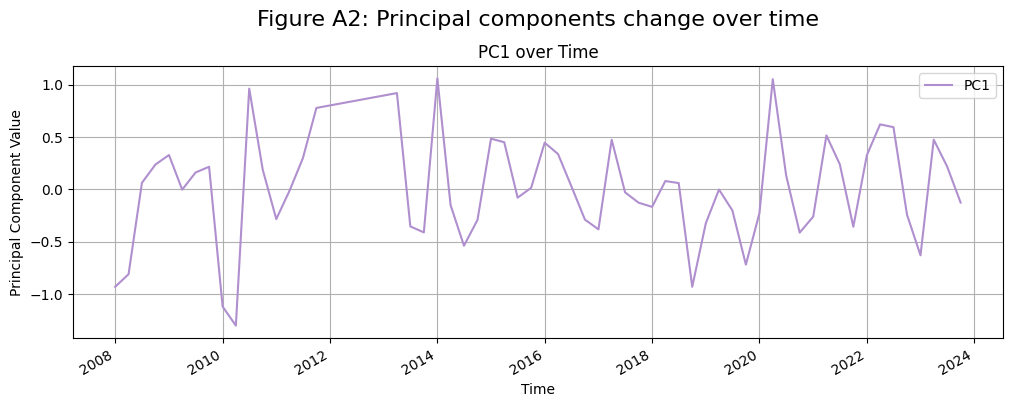

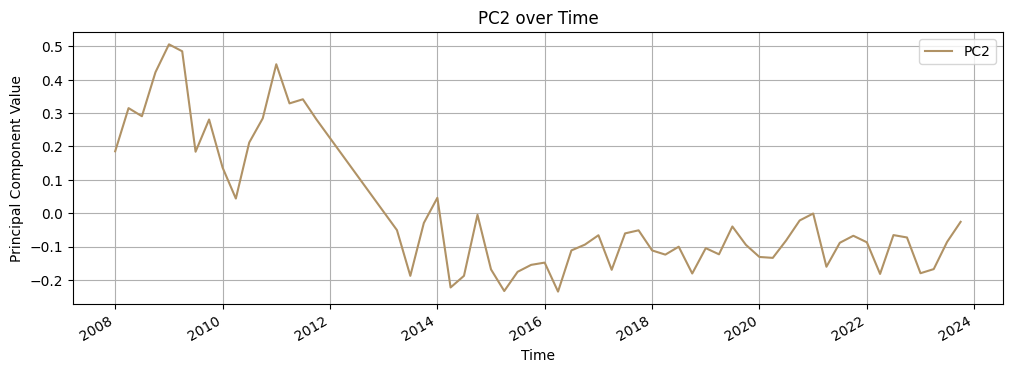

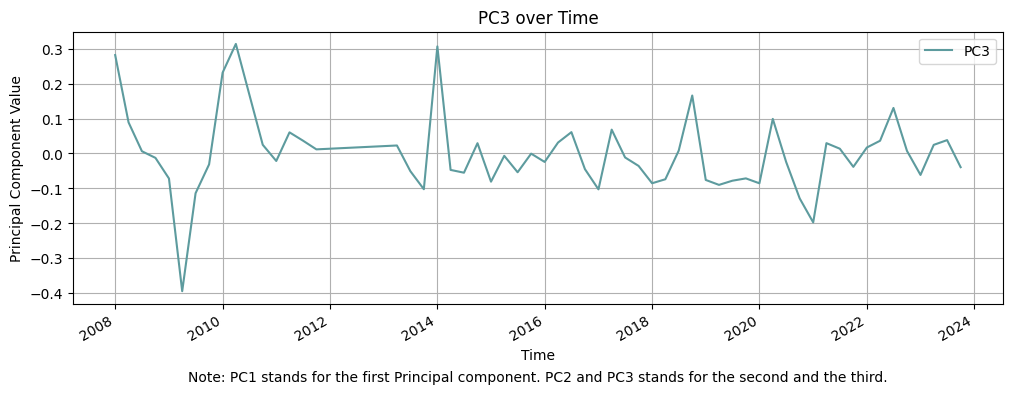

finished


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

pc_columns_to_plot = ['pc1', 'pc2', 'pc3']

# Define specific colors for each PC plot
# Using approximate hex codes for the requested colors, adjusted for brightness
color_map = {
    'pc1': '#B08FCF', # Adjusted brightness for Violet Quartz
    'pc2': '#B09265', # Adjusted brightness for Goldfinger
    'pc3': '#5D9B9E'  # Adjusted brightness for Cadet Blue
}


# draw plot
for col in pc_columns_to_plot:
    if col in PC.columns:
        fig, ax = plt.subplots(figsize=(12, 4)) # Create figure and axes for each plot

        # Use the color from the color_map if available, otherwise use default
        plot_color = color_map.get(col, None)
        if plot_color:
            # Use uppercase for label
            ax.plot(PC['time'], PC[col], label=col.upper(), color=plot_color)
        else:
             # Use uppercase for label
            ax.plot(PC['time'], PC[col], label=col.upper()) # Use default color if not in map


        # Use uppercase for title
        ax.set_title(f'{col.upper()} over Time') # Added " over Time" for clarity
        ax.set_xlabel('Time')
        ax.set_ylabel('Principal Component Value')

        ax.legend()

        # Autoformat x-axis dates
        fig.autofmt_xdate()

        ax.grid(True)

        # --- Add text based on the current PC ---
        if col == 'pc1':
            # Add Figure label and common Title above the PC1 plot
            fig.text(0.5, 1.17, 'Figure A2: Principal components change over time',
                     ha='center', va='center', transform=ax.transAxes, fontsize=16)

        elif col == 'pc3':
            # Add Note below the PC3 plot
            fig.text(0.5, -0.27, 'Note: PC1 stands for the first Principal component. PC2 and PC3 stands for the second and the third.',
                     ha='center', va='center', transform=ax.transAxes, fontsize=10, wrap=True)


        # --- End of conditional text addition ---


        plt.show()
    else:
        print(f"'{col}'not found")

print("finished")


**seasonal test**

In [ ]:
import pandas as pd
import statsmodels.api as sm

if 'PC' not in locals():
    print("PC not found")
else:
    # get quaeter dummy
    PC['quarter'] = PC['time'].dt.quarter
    quarter_dummies = pd.get_dummies(PC['quarter'], prefix='Q', drop_first=True)

    # add dummy into PC
    PC_with_dummies = PC.join(quarter_dummies)

    print("DataFrame with quarter dummies added:")
    display(PC_with_dummies.head())


DataFrame with quarter dummies added:


,time,pc1,pc2,pc3,quarter,Q_2,Q_3,Q_4
0,2008-01-01,-0.930701,0.185353,0.281816,1,False,False,False
1,2008-04-01,-0.810655,0.314787,0.089018,2,True,False,False
2,2008-07-01,0.061691,0.290403,0.006259,3,False,True,False
3,2008-10-01,0.236543,0.422133,-0.012724,4,False,False,True
4,2009-01-01,0.327092,0.505859,-0.071886,1,False,False,False


In [ ]:
import statsmodels.api as sm
import pandas as pd # Ensure pandas is imported if not already

# Define dependent (PCs) and independent (quarter dummies) variables
dependent_variables = ['pc1', 'pc2', 'pc3']
independent_variables = ['Q_2', 'Q_3', 'Q_4']

print("Seasonal Test Results (Simplified):")

# Perform regression for each principal component
for pc_col in dependent_variables:
    print(f"\n--- Regression for {pc_col} ---")

    # Prepare data, dropping rows with NaNs in relevant columns
    # Explicitly convert boolean dummy variables to integers (0 or 1)
    temp_df = PC_with_dummies[[pc_col] + independent_variables].copy().dropna()
    for col in independent_variables:
        if col in temp_df.columns:
            temp_df[col] = temp_df[col].astype(int)


    if temp_df.empty:
        print("No data available for regression after dropping NaNs.")
        continue

    # Add a constant and fit OLS model
    X = sm.add_constant(temp_df[independent_variables])
    y = temp_df[pc_col]

    try:
        model = sm.OLS(y, X).fit()
        print(model.summary())

        # Perform and print F-test result
        # Ensure the variables for the F-test exist in the model
        f_test_vars = [var for var in independent_variables if var in model.params.index]
        if f_test_vars:
            f_test = model.f_test(f_test_vars)
            # Corrected way to access the p-value
            print(f"F-test ({', '.join(f_test_vars)} p-value): {f_test.pvalue:.4f}")

            alpha = 0.05
            # Access p-value correctly here as well
            conclusion = "statistically significant seasonal effect." if f_test.pvalue < alpha else "no statistically significant seasonal effect."
            print(f"Conclusion: {conclusion}")
        else:
            print("No dummy variables included in the model for F-test.")


    except Exception as e:
        print(f"Error during regression or F-test for {pc_col}: {e}")

print("\nSeasonal Test task finished.")

Seasonal Test Results (Simplified):

--- Regression for pc1 ---
                            OLS Regression Results                            
Dep. Variable:                    pc1   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     1.606
Date:                Thu, 07 Aug 2025   Prob (F-statistic):              0.198
Time:                        21:30:02   Log-Likelihood:                -41.488
No. Observations:                  59   AIC:                             90.98
Df Residuals:                      55   BIC:                             99.29
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

Seasonal Strength Analysis

=== pc1 Seasonal Analysis ===
Seasonal Strength: 0.1403
Seasonal Component Std Dev: 0.1667
Seasonal Component Range: 0.3974
Seasonal Strength Assessment: Weak seasonality

=== pc2 Seasonal Analysis ===
Seasonal Strength: 0.1409
Seasonal Component Std Dev: 0.0256
Seasonal Component Range: 0.0672
Seasonal Strength Assessment: Weak seasonality

=== pc3 Seasonal Analysis ===
Seasonal Strength: 0.0415
Seasonal Component Std Dev: 0.0163
Seasonal Component Range: 0.0459
Seasonal Strength Assessment: Weak seasonality


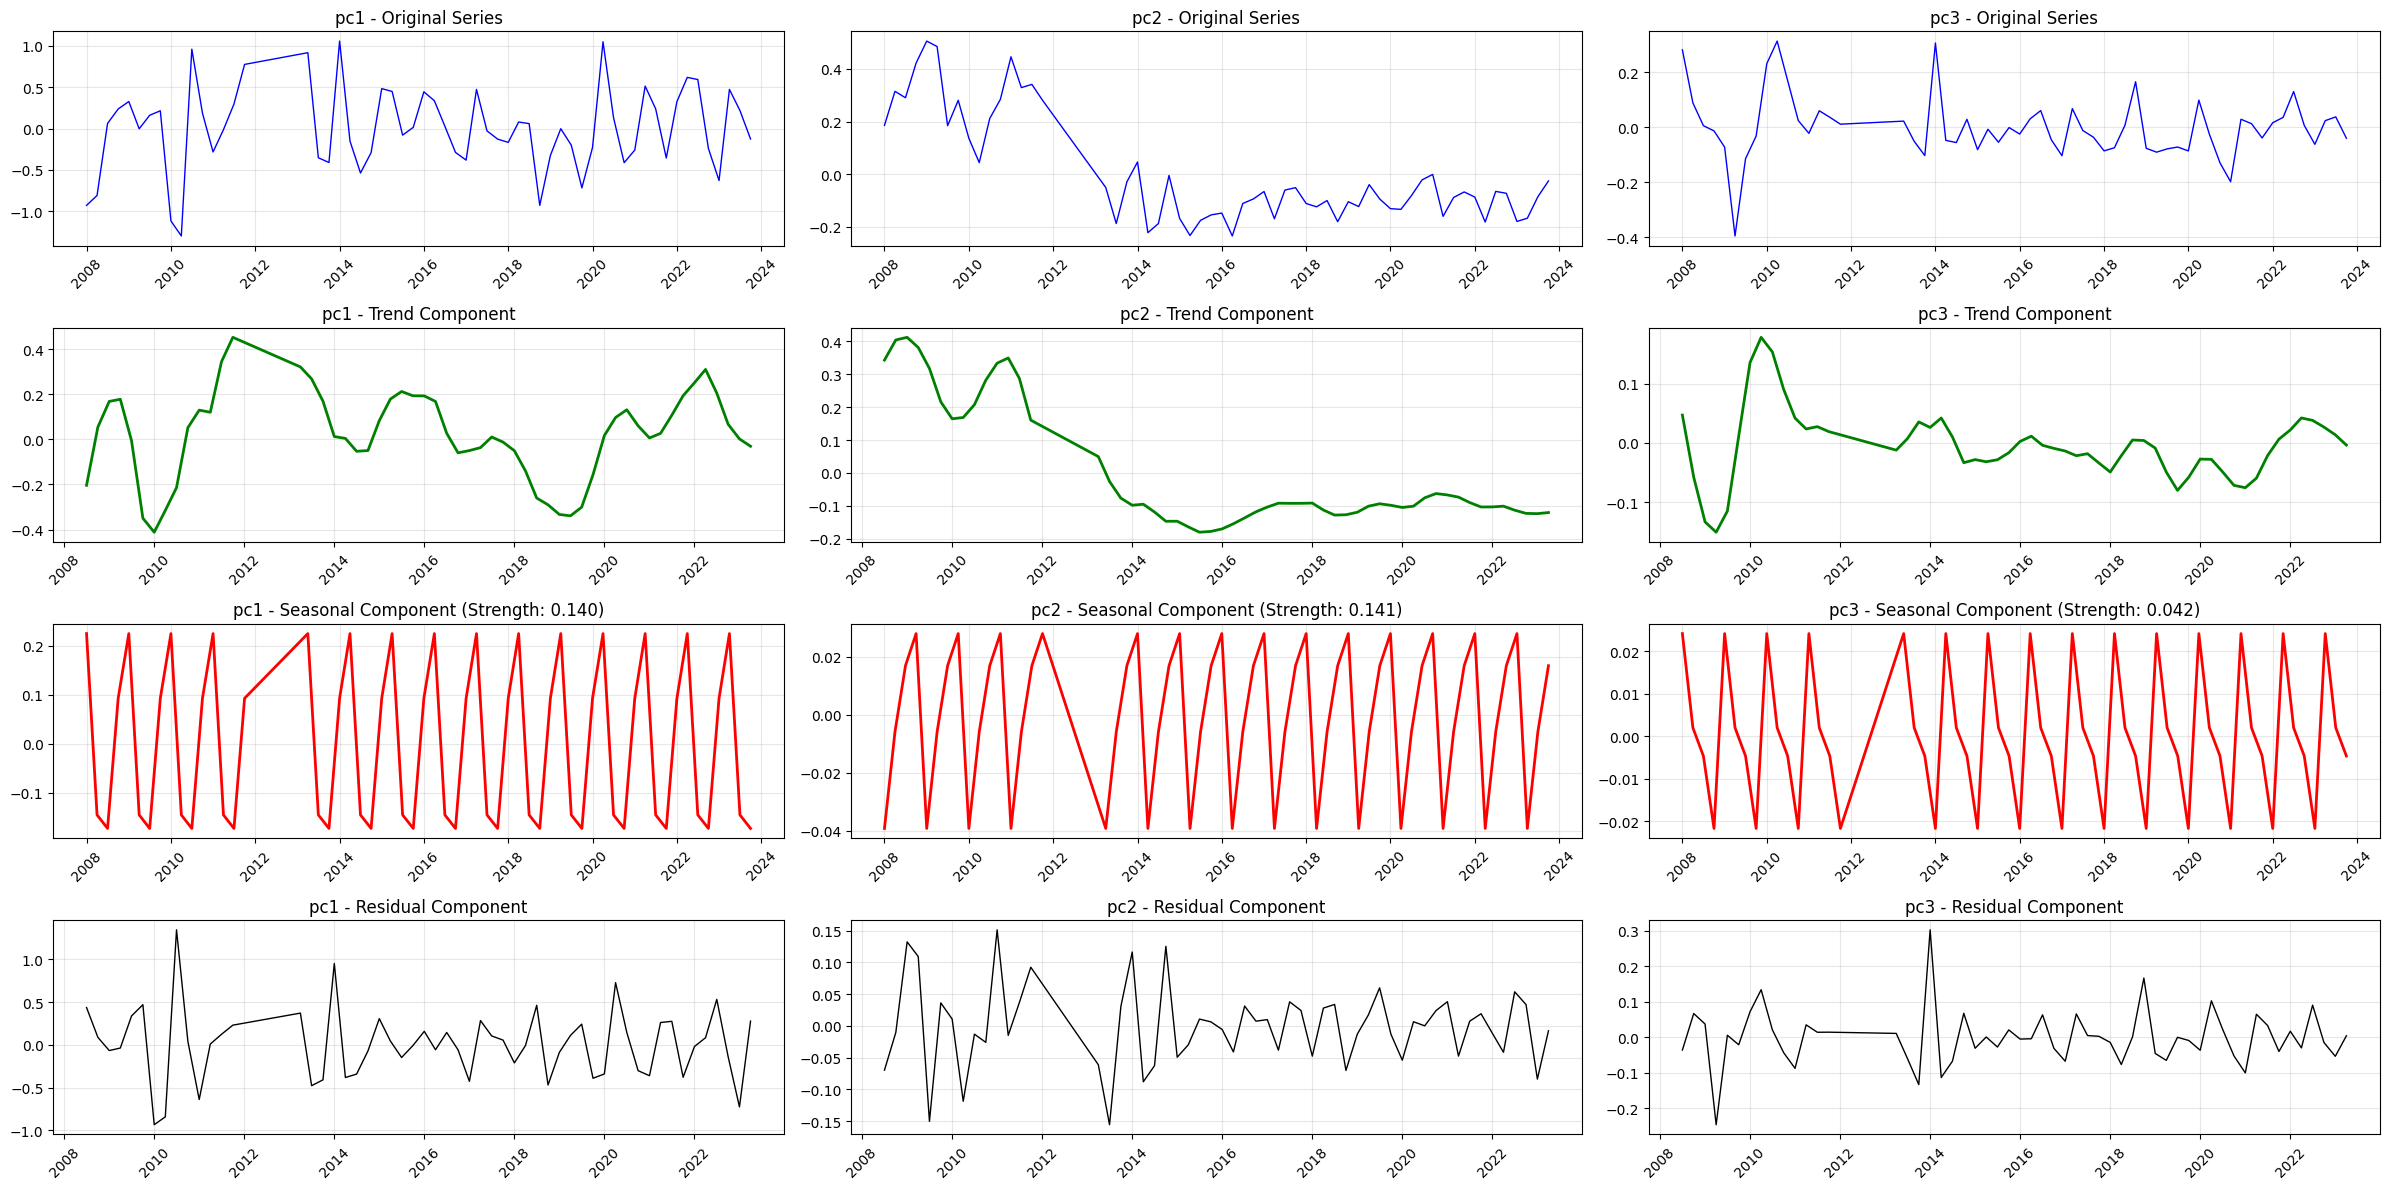


Seasonal Strength Comparison Summary
pc1          | Seasonal Strength: 0.1403 | Weak seasonality
pc2          | Seasonal Strength: 0.1409 | Weak seasonality
pc3          | Seasonal Strength: 0.0415 | Weak seasonality


In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np # Import numpy

# Set a common font family to avoid warnings
plt.rcParams['font.family'] = 'DejaVu Sans'


# Line plot and statistical description of variables
variables_to_analyze = ['pc1', 'pc2', 'pc3'] # Use the actual PC columns
existing_vars = [var for var in variables_to_analyze if var in PC.columns] # Use PC DataFrame

# Seasonal strength analysis function
def analyze_seasonal_strength(df, variables):
    """
    Analyze the seasonal strength of variables
    """
    print("="*60)
    print("Seasonal Strength Analysis")
    print("="*60)

    # First, set 'time' as the index for seasonal decomposition
    df_temp = df.set_index('time').copy()

    seasonal_results = {}

    for var in variables:
        if var in df.columns:
            print(f"\n=== {var} Seasonal Analysis ===")

            # Get data and remove missing values
            series = df_temp[var].dropna()

            # Check data length
            if len(series) < 8:  # Quarterly data needs at least 8 observations (2 years)
                print(f"⚠️ {var} Data length insufficient for seasonal decomposition")
                continue

            try:
                # Seasonal decomposition (quarterly data, period 4)
                decomposition = seasonal_decompose(series, model='additive', period=4)

                # Calculate seasonal strength indicators
                seasonal_component = decomposition.seasonal
                residual_component = decomposition.resid.dropna()

                # Seasonal strength = Variance of seasonal component / Variance of residual component
                seasonal_var = np.var(seasonal_component)
                residual_var = np.var(residual_component)
                # Add a small epsilon to the denominator to prevent division by zero
                seasonal_strength = seasonal_var / (seasonal_var + residual_var + 1e-10)


                # Other seasonality indicators
                seasonal_range = seasonal_component.max() - seasonal_component.min()
                seasonal_std = np.std(seasonal_component)

                print(f"Seasonal Strength: {seasonal_strength:.4f}")
                print(f"Seasonal Component Std Dev: {seasonal_std:.4f}")
                print(f"Seasonal Component Range: {seasonal_range:.4f}")


                # Interpret seasonal strength
                if seasonal_strength > 0.6:
                    strength_desc = "Strong seasonality"
                elif seasonal_strength > 0.3:
                    strength_desc = "Moderate seasonality"
                else:
                    strength_desc = "Weak seasonality"

                print(f"Seasonal Strength Assessment: {strength_desc}")


                # Save results
                seasonal_results[var] = {
                    'seasonal_strength': seasonal_strength,
                    'seasonal_std': seasonal_std,
                    'seasonal_range': seasonal_range,
                    'description': strength_desc,
                    'decomposition': decomposition
                }

            except Exception as e:
                print(f"❌ {var} Seasonal decomposition failed: {str(e)}")


    return seasonal_results

# Seasonal decomposition visualization function
def plot_seasonal_decomposition(seasonal_results):
    """
    Plot seasonal decomposition
    """
    # Set a common font family to avoid warnings
    plt.rcParams['font.family'] = 'DejaVu Sans'

    n_vars = len(seasonal_results)
    if n_vars == 0:
        print("No seasonal decomposition results to plot")
        return

    fig, axes = plt.subplots(4, n_vars, figsize=(8*n_vars, 12))
    if n_vars == 1:
        axes = axes.reshape(-1, 1)

    for i, (var, result) in enumerate(seasonal_results.items()):
        decomp = result['decomposition']

        # Original series
        axes[0, i].plot(decomp.observed.index, decomp.observed.values, 'b-', linewidth=1)
        axes[0, i].set_title(f'{var} - Original Series')
        axes[0, i].grid(True, alpha=0.3)

        # Trend component
        axes[1, i].plot(decomp.trend.index, decomp.trend.values, 'g-', linewidth=2)
        axes[1, i].set_title(f'{var} - Trend Component')
        axes[1, i].grid(True, alpha=0.3)

        # Seasonal component
        axes[2, i].plot(decomp.seasonal.index, decomp.seasonal.values, 'r-', linewidth=2)
        axes[2, i].set_title(f'{var} - Seasonal Component (Strength: {result["seasonal_strength"]:.3f})')
        axes[2, i].grid(True, alpha=0.3)

        # Residual component
        axes[3, i].plot(decomp.resid.index, decomp.resid.values, 'k-', linewidth=1)
        axes[3, i].set_title(f'{var} - Residual Component')
        axes[3, i].grid(True, alpha=0.3)

        # Rotate x-axis labels
        for j in range(4):
            axes[j, i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


# Perform seasonal strength analysis
variables_to_analyze = ['pc1', 'pc2', 'pc3'] # Use the actual PC columns
existing_vars_to_analyze = [var for var in variables_to_analyze if var in PC.columns] # Use PC DataFrame

if existing_vars_to_analyze:
    # Analyze seasonal strength
    seasonal_results = analyze_seasonal_strength(PC, existing_vars_to_analyze) # Pass PC DataFrame

    # Plot seasonal decomposition
    if seasonal_results:
        plot_seasonal_decomposition(seasonal_results)

        # Summary comparison
        print("\n" + "="*60)
        print("Seasonal Strength Comparison Summary")
        print("="*60)
        for var, result in seasonal_results.items():
            print(f"{var:12} | Seasonal Strength: {result['seasonal_strength']:.4f} | {result['description']}")
    else:
        print("Seasonal decomposition failed for all variables")
else:
    print("Variables for seasonal analysis not found in the DataFrame.")

**ADF test**

In [ ]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

pc_columns = ['pc1', 'pc2', 'pc3']
alpha = 0.05

print("ADF test result (alpha=0.05):")
for col in pc_columns:
    if col in PC.columns and PC[col].dropna().shape[0] >= 8:
        result = adfuller(PC[col].dropna())
        print(f"'{col}': p={result[1]:.4f}, lags={result[2]}, so: {'stationary' if result[1] < alpha else 'non-stationary'}")
    else:
        print(f"'{col}': Skip as no data")

ADF test result (alpha=0.05):
'pc1': p=0.0198, lags=9, so: stationary
'pc2': p=0.3414, lags=6, so: non-stationary
'pc3': p=0.0000, lags=1, so: stationary


,time,pc1,pc2,pc3,dpc2
0,2008-01-01,-0.930701,0.185353,0.281816,NaN
1,2008-04-01,-0.810655,0.314787,0.089018,0.129435
2,2008-07-01,0.061691,0.290403,0.006259,-0.024384
3,2008-10-01,0.236543,0.422133,-0.012724,0.131730
4,2009-01-01,0.327092,0.505859,-0.071886,0.083726


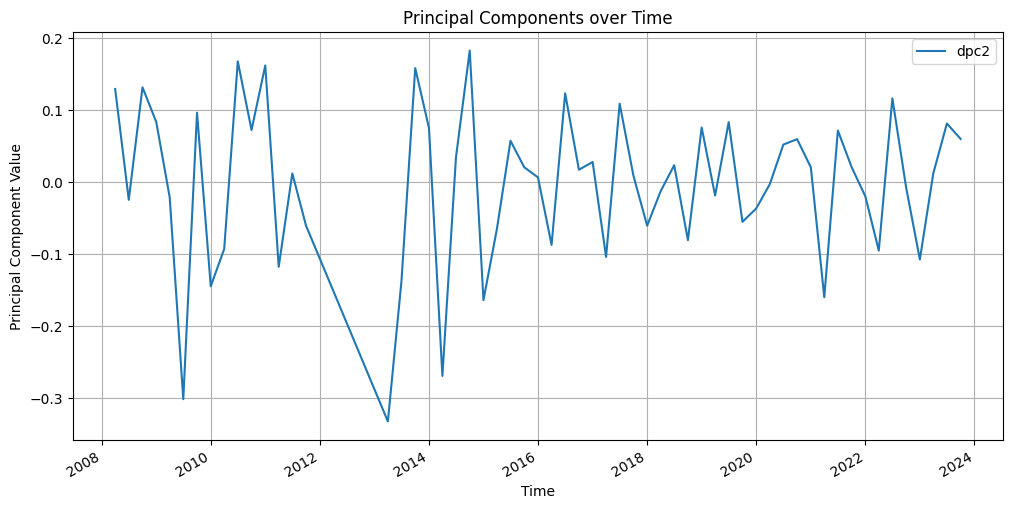

In [ ]:
import pandas as pd

# first difference
PC['dpc2'] = PC['pc2'].diff()

display(PC.head())

plt.figure(figsize=(12, 6))

plt.plot(PC['time'], PC['dpc2'], label='dpc2')

plt.title('Principal Components over Time')
plt.xlabel('Time')
plt.ylabel('Principal Component Value')

plt.legend()

plt.gcf().autofmt_xdate()

plt.grid(True)

plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

col_to_test = 'dpc2'
alpha = 0.05

print(f"ADF test result ({col_to_test}, alpha={alpha}):")
if col_to_test in PC.columns and PC[col_to_test].dropna().shape[0] >= 8:
    result = adfuller(PC[col_to_test].dropna())
    print(f"'{col_to_test}': p={result[1]:.4f}, lags={result[2]}, so: {'stationary' if result[1] < alpha else 'non-stationary'}")
else:
    print(f"'{col_to_test}': Skip")

ADF test result (dpc2, alpha=0.05):
'dpc2': p=0.0000, lags=5, so: stationary


In [ ]:
# Define the save path in Google Drive
save_path = '/content/drive/My Drive/PC.csv'

# Save the DataFrame to CSV
PC.to_csv(save_path, index=False)

print(f"DataFrame successfully saved to {save_path}")

DataFrame successfully saved to /content/drive/My Drive/PC.csv


# use PCA and difference in the whole sample

In [ ]:
# Assuming 'pca' is the fitted PCA model from processing the 'data' DataFrame
# And 'feature_columns' is the list of columns used for PCA fitting

# Apply the PCA transformation to the full df DataFrame
# Make sure to select the same feature columns as used for fitting PCA
principal_components_df_full = pca.transform(df[feature_columns])

# Create a DataFrame with the first 3 principal components
pc_df_full = pd.DataFrame(principal_components_df_full[:, :3], columns=['pc1', 'pc2', 'pc3'], index=df.index)

# Drop existing 'pc1', 'pc2', 'pc3' columns from df if they exist, to avoid overlap error
existing_pc_columns = ['pc1', 'pc2', 'pc3']
df = df.drop(columns=[col for col in existing_pc_columns if col in df.columns])

# Join the new principal components DataFrame to the original df DataFrame
# Use .copy() to avoid SettingWithCopyWarning if 'df' is a slice
df = df.join(pc_df_full)

display(df.head())

In [ ]:
# Calculate the cumulative explained variance for the first 3 components
cumulative_variance_first_3_pcs = pca.explained_variance_ratio_[:3].sum()

print(f"Cumulative explained variance ratio of the first 3 PCs: {cumulative_variance_first_3_pcs:.4f} in data")


# Get the original feature data from df
original_features_df = df[feature_columns]

# Calculate the total variance of the original feature data in df
total_variance_df = original_features_df.var().sum()

# Get the first 3 principal components from the transformed data of df
# This data is already available after running cell 'b7ebc879'
principal_components_df_full_first_3 = df[['pc1', 'pc2', 'pc3']]

# Calculate the variance of each of the first 3 principal components in df
variance_of_pcs_in_df = principal_components_df_full_first_3.var()

# Sum the variances of the first 3 principal components in df
sum_variance_of_pcs_in_df = variance_of_pcs_in_df.sum()

# Calculate the estimated proportion of variance explained in df by the first 3 PCs
# Add a small epsilon to the denominator to prevent division by zero
epsilon = 1e-10
explained_variance_ratio_on_df = sum_variance_of_pcs_in_df / (total_variance_df + epsilon)


print(f"Cumulative explained variance ratio of the first 3 PCs: {explained_variance_ratio_on_df:.4f} in df")

In [ ]:
# Keep only 'time', 'pc1', 'pc2', and 'pc3' columns
df = df[['time', 'pc1', 'pc2', 'pc3']].copy()

# Calculate the first difference of 'pc2' and store in 'dpc2'
df['dpc2'] = df['pc2'].diff()

display(df.head(2))
display(df.tail())

In [ ]:
# Define the save path in Google Drive
save_path = '/content/drive/My Drive/PC_final.csv'

# Save the DataFrame to CSV
df.to_csv(save_path, index=False)

print(f"DataFrame successfully saved to {save_path}")

In [ ]:
!pip install rasterio

In [ ]:
# Replace with the actual path to one of your image files
# For example, using the path from the first row of your image DataFrame
image_file_path = image.loc[0, 'image_path']

# Run the gdalinfo command
!gdalinfo "{image_file_path}"

/bin/bash: line 1: gdalinfo: command not found


In [ ]:
import rasterio

# Replace with the actual path to one of your image files
# For example, using the path from the first row of your image DataFrame
image_file_path = image.loc[0, 'image_path']

try:
    with rasterio.open(image_file_path) as src:
        print(f"File Path: {image_file_path}")
        print(f"Driver (Format): {src.driver}")
        print(f"Number of bands: {src.count}")
        print("Band data types:")
        for i, dtype in enumerate(src.dtypes):
            print(f"  Band {i+1}: {dtype}")

except Exception as e:
    print(f"Error opening or reading file {image_file_path}: {e}")

File Path: /content/drive/My Drive/landsat5/p08-1.tif
Driver (Format): GTiff
Number of bands: 19
Band data types:
  Band 1: float64
  Band 2: float64
  Band 3: float64
  Band 4: float64
  Band 5: float64
  Band 6: float64
  Band 7: float64
  Band 8: float64
  Band 9: float64
  Band 10: float64
  Band 11: float64
  Band 12: float64
  Band 13: float64
  Band 14: float64
  Band 15: float64
  Band 16: float64
  Band 17: float64
  Band 18: float64
  Band 19: float64


## Visualize PCA Explained Variance (Scree Plot)

Visualize the explained variance ratio of each principal component and the cumulative explained variance ratio using a scree plot. This helps in determining how many principal components to retain.

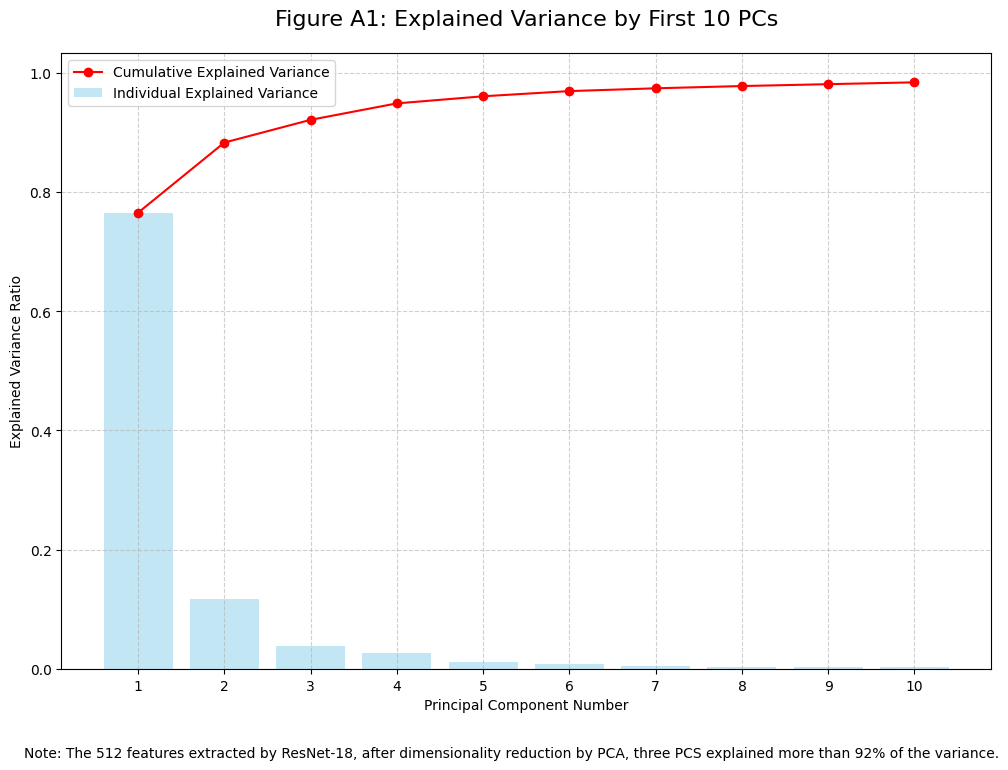

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Explicitly reset matplotlib font settings
mpl.rcParams.update(mpl.rcParamsDefault)

# Remove the line setting font to Arial to use default font
# plt.rcParams['font.family'] = 'Arial' # Removed

# Define the number of components to display
n_components_to_display = 10

# Ensure we don't try to display more components than available
# Assuming pca model is fitted and explained_variance_ratio is available
if 'pca' in locals() and hasattr(pca, 'explained_variance_ratio_'):
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = explained_variance_ratio.cumsum()
    n_components_to_display = min(n_components_to_display, len(explained_variance_ratio))

    components = range(1, n_components_to_display + 1)

    plt.figure(figsize=(12, 8)) # Increase figure height to accommodate text below

    # Plot explained variance ratio of each component as bars (up to n_components_to_display)
    plt.bar(components, explained_variance_ratio[:n_components_to_display], alpha=0.5, align='center', label='Individual Explained Variance', color='skyblue')

    # Plot cumulative explained variance ratio as a line (up to n_components_to_display)
    plt.plot(components, cumulative_explained_variance[:n_components_to_display], marker='o', linestyle='-', color='red', label='Cumulative Explained Variance')

    plt.xlabel('Principal Component Number')
    plt.ylabel('Explained Variance Ratio')
    # Modified title as requested, adjusted vertical position with pad
    plt.title('Figure A1: Explained Variance by First 10 PCs', fontsize=16, pad=20) # Increased pad value


    plt.xticks(components) # Ensure x-axis ticks are at each component number
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    # --- Attempt to add Figure label and Note within the plot area ---
    # These coordinates might need adjustment based on the actual plot size and layout
    fig = plt.gcf()
    # Using fig.text for placing text relative to the figure
    # Adjusted y coordinate to try and improve placement
    fig.text(0.5, 0, 'Note: The 512 features extracted by ResNet-18, after dimensionality reduction by PCA, three PCS explained more than 92% of the variance.',
             ha='center', fontsize=10, wrap=True) # Adjusted y and added wrap=True for multi-line

    # --- End of text addition attempt ---


    plt.show()

else:
     print("PCA model not fitted. Please run PCA calculation first.") # Keep a basic check

## Explained Variance by First 10 Principal Components

Below is a table showing the individual explained variance ratio and the cumulative explained variance ratio for the first 10 principal components.

In [ ]:
import pandas as pd

# Ensure pca model is fitted and variance ratios are available
if 'pca' in locals() and hasattr(pca, 'explained_variance_ratio_'):
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = explained_variance_ratio.cumsum()

    # Define the number of components to include in the table
    n_components_in_table = 10

    # Ensure we don't try to include more components than available
    n_components_in_table = min(n_components_in_table, len(explained_variance_ratio))

    # Create a DataFrame for the table
    table_data = {
        'Principal Component': range(1, n_components_in_table + 1),
        'Explained Variance Ratio': explained_variance_ratio[:n_components_in_table],
        'Cumulative Explained Variance Ratio': cumulative_explained_variance[:n_components_in_table]
    }

    explained_variance_table = pd.DataFrame(table_data)

    # --- Apply advanced styling for academic look based on image ---
    # Set decimal precision and apply styles directly
    styled_table = explained_variance_table.style \
        .format({
            'Explained Variance Ratio': '{:.4f}',
            'Cumulative Explained Ratio': '{:.4f}'
        }) \
        .set_properties(**{'text-align': 'center'}) \
        .set_table_styles([
            # Apply style to table headers (<th>) - trying a different approach
            {'selector': 'th', 'props': [
                ('border-bottom', '1px solid black'),
                ('border-top', '1px solid black'),
                ('text-align', 'center'),
                ('font-size', 'x-small') # Using a predefined size like 'x-small' or 'smaller'
            ]},
            {'selector': 'td', 'props': [('text-align', 'center')]},
            {'selector': '', 'props': [('border-collapse', 'collapse')]} # Remove default borders
        ]) \
        .hide(axis="index") \
        .set_caption("Table A1") # Add the caption here


    # Remove the previous print statement
    # print("Explained Variance by First 10 Principal Components (Academic Style):")
    # Display the styled table
    display(styled_table)

else:
    print("PCA model not fitted or variance ratios not available. Please run PCA calculation first.")

Principal Component,Explained Variance Ratio,Cumulative Explained Variance Ratio
1,0.7653,0.765254
2,0.1176,0.882891
3,0.0381,0.921030
4,0.0276,0.948623
5,0.0119,0.960520
6,0.0087,0.969219
7,0.0047,0.973900
8,0.0038,0.977687
9,0.0031,0.980833
10,0.0031,0.983919


,time,pc1,pc2,pc3,dpc2
0,2008-01-01,-0.930701,0.185353,0.281816,NaN
1,2008-04-01,-0.810655,0.314787,0.089018,0.129435
2,2008-07-01,0.061691,0.290403,0.006259,-0.024384
3,2008-10-01,0.236543,0.422133,-0.012724,0.131730
4,2009-01-01,0.327092,0.505859,-0.071886,0.083726


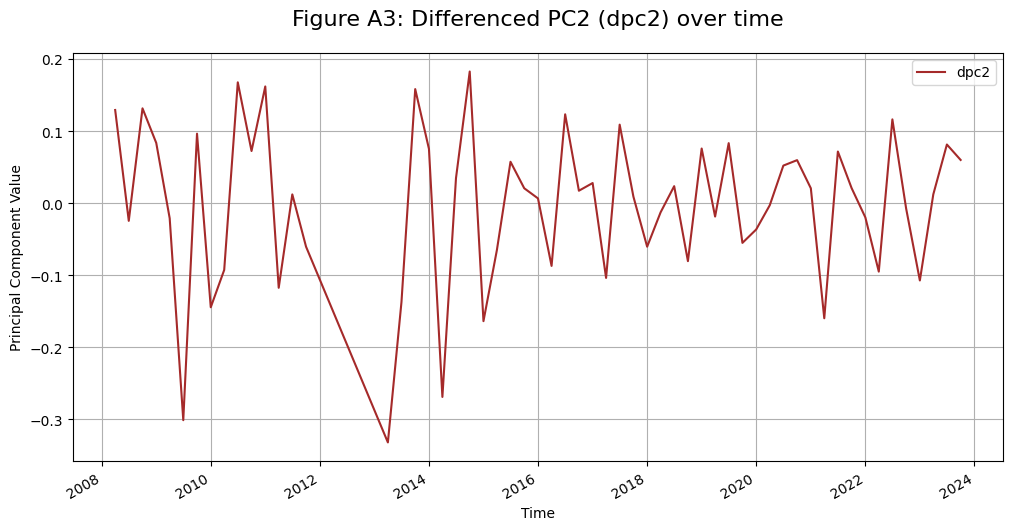

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt # Ensure matplotlib is imported

# first difference
PC['dpc2'] = PC['pc2'].diff()

display(PC.head())

plt.figure(figsize=(12, 6))

# Plot with brown color
plt.plot(PC['time'], PC['dpc2'], label='dpc2', color='brown')

# Set the specified title
plt.title('Figure A3: Differenced PC2 (dpc2) over time', fontsize=16, pad=20)
plt.xlabel('Time')
plt.ylabel('Principal Component Value') # Keep original ylabel as in the selected code

plt.legend()

plt.gcf().autofmt_xdate()

plt.grid(True)

plt.show()

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Ensure PC DataFrame is available
if 'PC' in locals() and isinstance(PC, pd.DataFrame):
    variables_to_test = ['pc1', 'pc2', 'pc3', 'dpc2']

    print("--- Full ADF Test Results ---")

    for var in variables_to_test:
        if var in PC.columns:
            print(f"\nADF Test for '{var}':")

            # Get the time series data, dropping NaNs if any (ADF test requires no NaNs)
            series = PC[var].dropna()

            if len(series) > 0:
                try:
                    # Perform the ADF test
                    # 'ct' includes a constant and a trend
                    # 'c' includes only a constant (often suitable for differenced series)
                    # 'nc' includes neither
                    # Choosing 'c' as a common assumption, adjust if needed
                    # Use 'ct' for 'pc2' to include a trend term
                    regression_type = 'ct' if var == 'pc2' else 'c'
                    print(f"  Regression type: '{regression_type}'") # Add this line to show regression type
                    adf_test_result = adfuller(series, regression=regression_type)


                    # Extract and print the full results
                    print(f"  ADF Statistic: {adf_test_result[0]:.4f}")
                    print(f"  P-value: {adf_test_result[1]:.4f}")
                    print(f"  Number of Lags Used: {adf_test_result[2]}")
                    print(f"  Number of Observations Used: {adf_test_result[3]}")
                    print("  Critical Values:")
                    for key, value in adf_test_result[4].items():
                        print(f"    {key}: {value:.4f}")

                    # Optional: Print a conclusion based on the p-value
                    alpha = 0.05
                    conclusion = "stationary" if adf_test_result[1] < alpha else "non-stationary"
                    print(f"  Conclusion (at alpha={alpha}): {conclusion}")

                except Exception as e:
                    print(f"  Error during ADF test for '{var}': {e}")
            else:
                print(f"  '{var}' has no data after dropping NaNs.")

    print("\nADF Test task finished.")

else:
    print("DataFrame 'PC' not found or is not a DataFrame. Please ensure 'PC' is loaded.")

--- Full ADF Test Results ---

ADF Test for 'pc1':
  Regression type: 'c'
  ADF Statistic: -3.2029
  P-value: 0.0198
  Number of Lags Used: 9
  Number of Observations Used: 49
  Critical Values:
    1%: -3.5715
    5%: -2.9226
    10%: -2.5993
  Conclusion (at alpha=0.05): stationary

ADF Test for 'pc2':
  Regression type: 'ct'
  ADF Statistic: -1.0122
  P-value: 0.9424
  Number of Lags Used: 6
  Number of Observations Used: 52
  Critical Values:
    1%: -4.1443
    5%: -3.4986
    10%: -3.1784
  Conclusion (at alpha=0.05): non-stationary

ADF Test for 'pc3':
  Regression type: 'c'
  ADF Statistic: -5.2703
  P-value: 0.0000
  Number of Lags Used: 1
  Number of Observations Used: 57
  Critical Values:
    1%: -3.5507
    5%: -2.9138
    10%: -2.5946
  Conclusion (at alpha=0.05): stationary

ADF Test for 'dpc2':
  Regression type: 'c'
  ADF Statistic: -5.4600
  P-value: 0.0000
  Number of Lags Used: 5
  Number of Observations Used: 52
  Critical Values:
    1%: -3.5629
    5%: -2.9190
  